In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import glob
from tqdm import tqdm_notebook as tqdm

import jax.numpy as jnp

from astropy.table import Table
import pandas as pd
from astropy.io import fits

import pygtc
import pdb

from readcol import * 
from make_mask import *
from naming_script import *

import nrm_analysis as implaneia
from nrm_analysis.misctools import mask_definitions
from nrm_analysis.misctools import oifits

import yaml

f2f,mask = mask_definitions.jwst_g7s6c()


[files] = readcol('../data/noises_c.txt', twod=False)
[files2] = readcol('../data/noises_t.txt', twod=False)

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-039 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-040-001
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
ddir = '../data/candid_lowcon/candid_fit_results/'

In [3]:
ls *.yml

all_lowcon_candid_fits.yml


In [4]:
path = ddir+'all_lowcon_candid_fits.yml'
with open(path) as f:
    data = yaml.unsafe_load(f)
    
ddir2 = '../data/candid_highcon/candid_fit_results/'
path = ddir2+'all_highcon_candid_fits.yml'
with open(path) as f:
    data2 = yaml.unsafe_load(f)

ddir3 = './'
path = ddir3+'all_lowcon_candid_fits.yml'
with open(path) as f:
    data3 = yaml.unsafe_load(f)


In [5]:
def remap_angle(deg):
    return ((deg+180) % 360)-180

def parse_item(item):
    seps, dseps = [], []
    thetas, dthetas = [], []
    dms, ddms = [], []

    for key in item.keys():

        this = item[key]

        seps.append(this['best']['sep'])
        thetas.append(this['best']['theta'])
        dms.append(this['best']['dm'])

        dseps.append(this['uncer']['sep'])
        dthetas.append(this['uncer']['theta'])
        ddms.append(this['uncer']['dm'])

    seps = np.array(seps)
    thetas = np.array(thetas)
    dms = np.array(dms)
    dseps = np.array(dseps)
    dthetas = np.array(dthetas)
    ddms = np.array(ddms)
    
    return item.keys(), seps, thetas, dms, dseps, dthetas, ddms

def plot_all(contrast,dataset=data,pipeline='ImPlaneIA'):
    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15),sharex=True)

    true_mag = -2.5*np.log10(float(contrast))

    for sim in [0,45,90]:
        keys, seps, thetas, dms, dseps, dthetas, ddms = parse_item(dataset['%s_%d'%(contrast,sim)])
        my_xticks = np.array([(noisetup).replace('_',' ') for noisetup in keys])
        m = np.array(['bkgd' in tick for tick in my_xticks])
        s = np.argsort(m)

        bad = np.abs(dms-true_mag)>1

        seps[bad]=np.nan
        thetas[bad]=np.nan
        dms[bad]=np.nan
        dseps[bad]=np.nan
        dthetas[bad]=np.nan
        ddms[bad]=np.nan

        locations = 1.0*np.arange(len(seps))
        locations[~bad] = np.nan


        ax1.errorbar(np.arange(len(seps)),seps,yerr=dseps,linestyle='none',fmt='.',capsize=4,label=str(sim)+' deg')
        ax1.axhline(200,color='k',linestyle='--')
        ax1.tick_params(axis='both', which='major', labelsize=14)
        ax1.set_xlim(-0.5,len(seps+0.5))
        for loc in locations:
            if np.isfinite(loc):
                ax1.axvline(loc,color='k',alpha=0.3)

        ax2.errorbar(np.arange(len(thetas)),remap_angle(thetas)-sim,yerr=dthetas,linestyle='none',fmt='.',capsize=4)
        ax2.tick_params(axis='both', which='major', labelsize=14)
        ax2.axhline(0,color='k',linestyle='--')
        for loc in locations:
            if np.isfinite(loc):
                ax2.axvline(loc,color='k',alpha=0.3)

        ax3.errorbar(np.arange(len(dms)),remap_angle(dms),yerr=ddms,linestyle='none',fmt='.',capsize=4)
        ax3.tick_params(axis='both', which='major', labelsize=14)
        ax3.axhline(true_mag,color='k',linestyle='--')
        for loc in locations:
            if np.isfinite(loc):
                ax3.axvline(loc,color='k',alpha=0.3)


    ax1.set_xticks(np.arange(len(seps)))
    ax1.set_xticklabels([],fontsize=16)
    ax1.set_ylabel('Separation (mas)', fontsize=20)
    ax1.legend(fontsize=14)

    ax2.set_xticks(np.arange(len(thetas)))
    ax2.set_xticklabels([])
    ax2.set_ylabel('Δθ (deg)',fontsize=20)

    ax3.set_xticks(np.arange(len(thetas)))
    ax3.set_xticklabels([])
    ax3.set_ylabel('Δmag',fontsize=20);

    ax1.set_title('%s: Contrast %s' % (pipeline,contrast),fontsize=24,y=1.02)

    ax3.set_xticklabels(my_xticks,rotation=90);
    plt.savefig('candid_outputs_%s_%s.png' % (contrast,pipeline.lower()),bbox_inches='tight',facecolor='white')

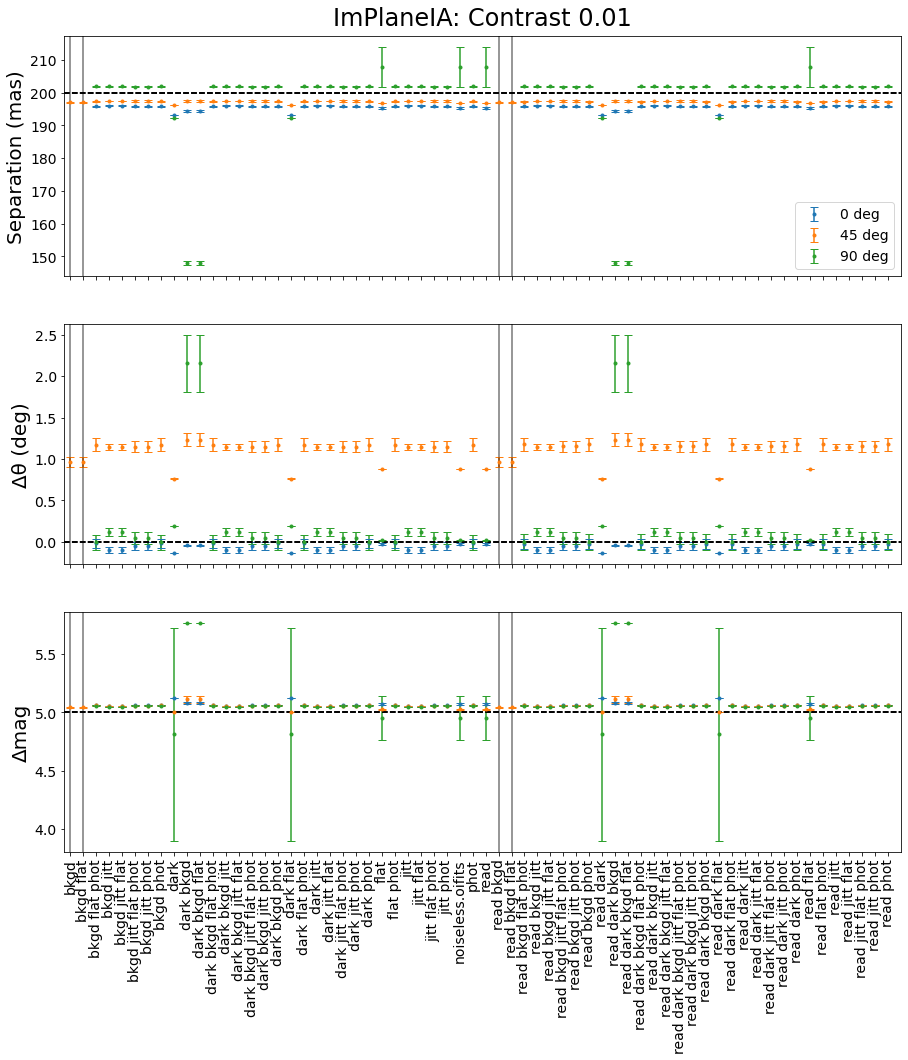

In [6]:
plot_all(0.01)

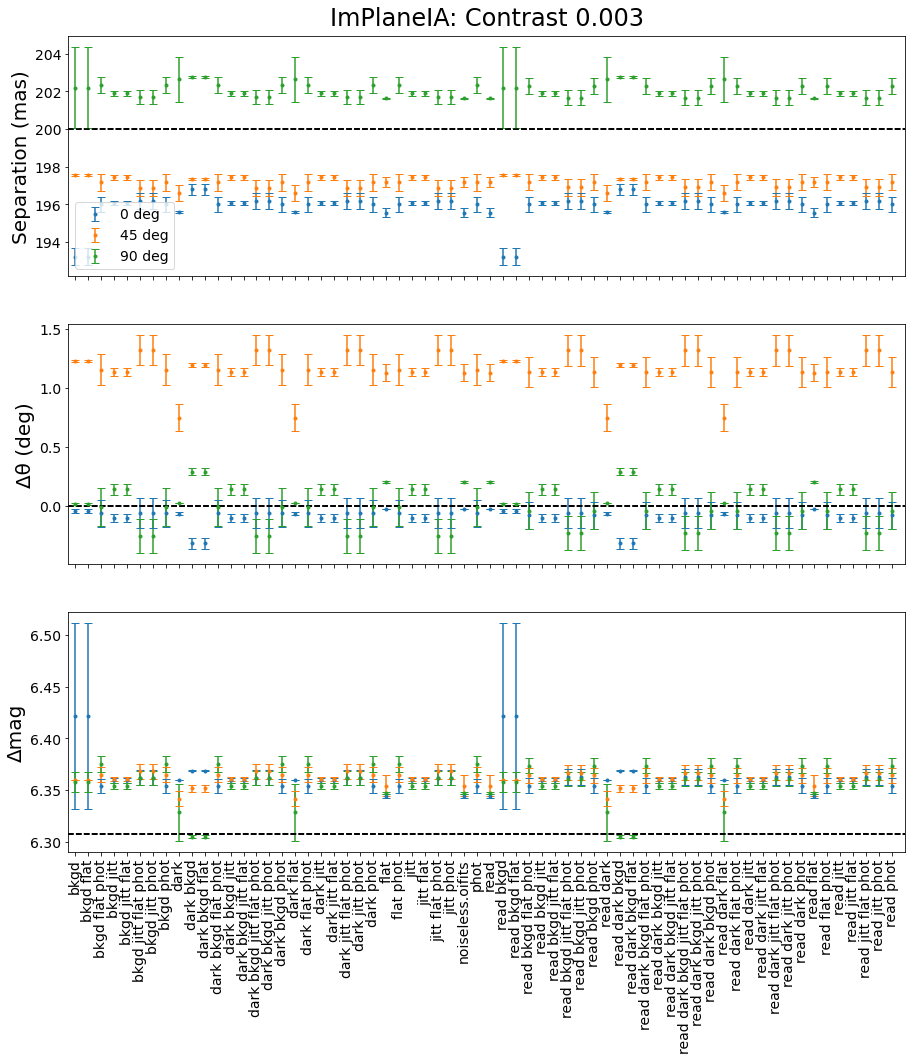

In [7]:
plot_all(0.003)

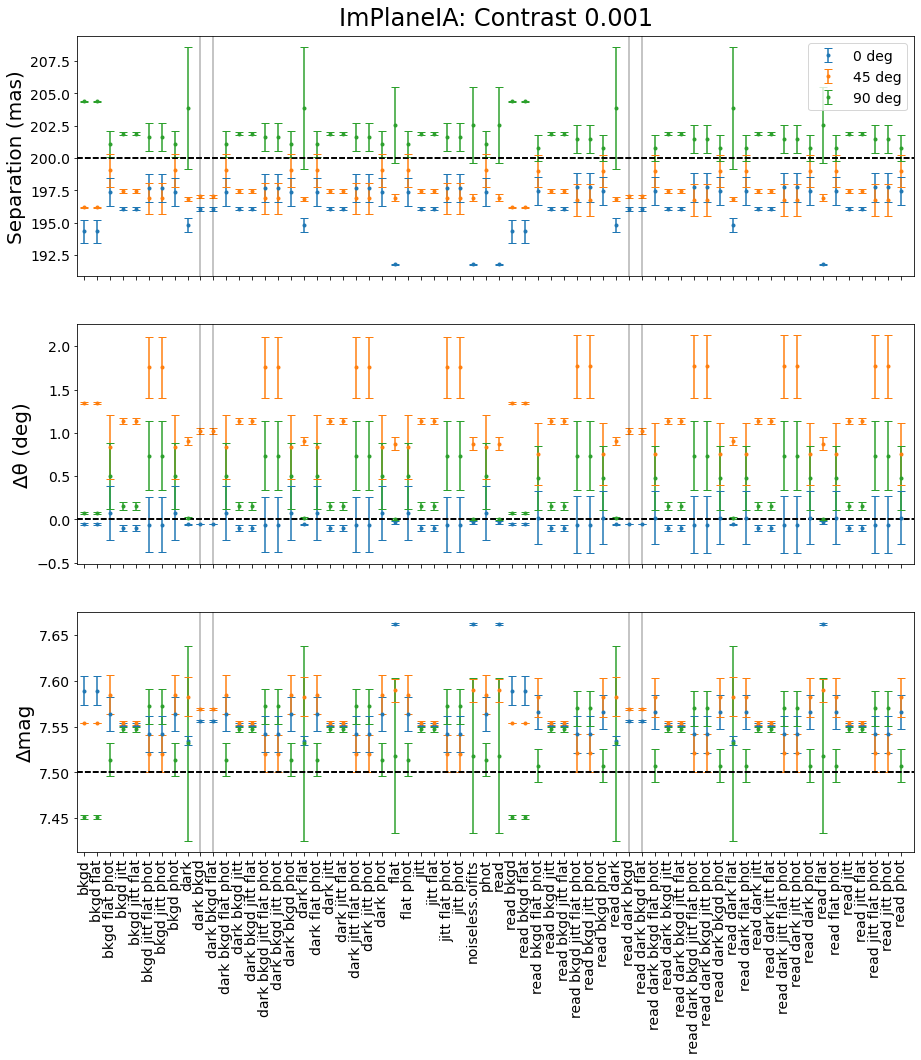

In [8]:
plot_all(0.001)

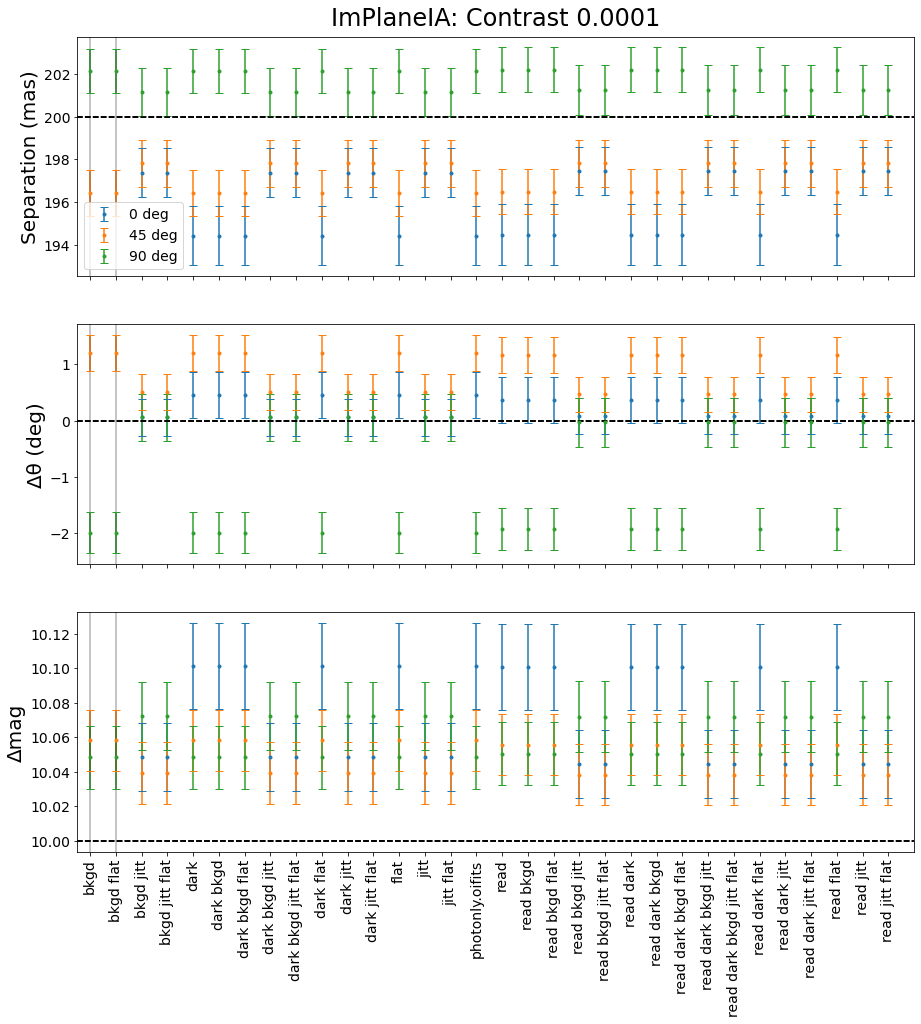

In [9]:
plot_all(0.0001,dataset=data2)

### How does AMICal do?

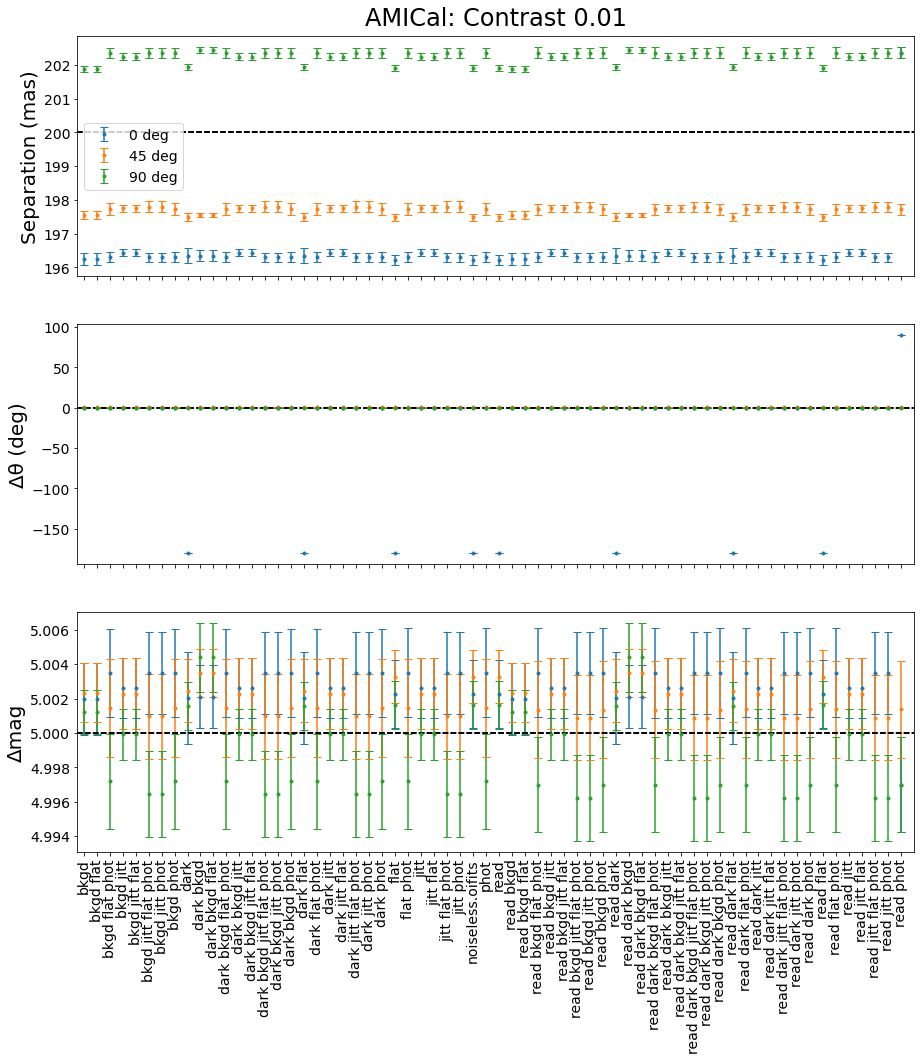

In [10]:
plot_all(0.01,dataset=data3,pipeline='AMICal')

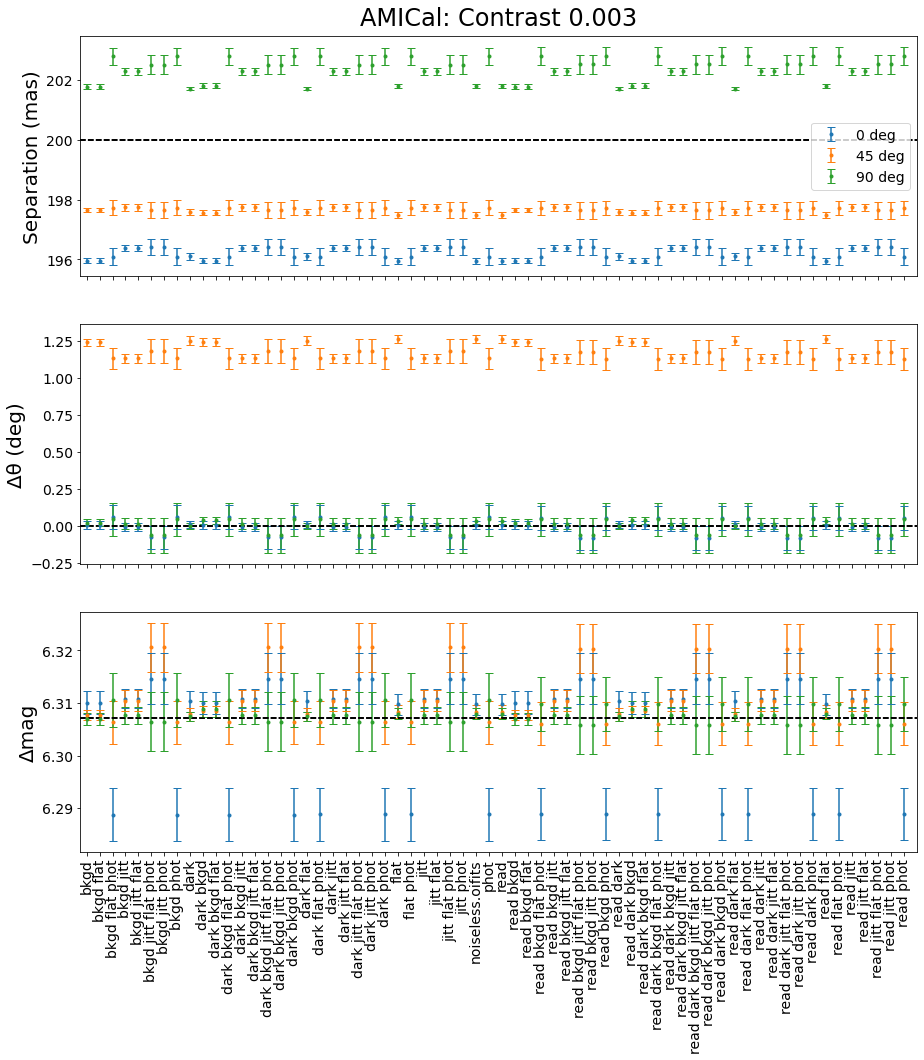

In [11]:
plot_all(0.003,dataset=data3,pipeline='AMICal')

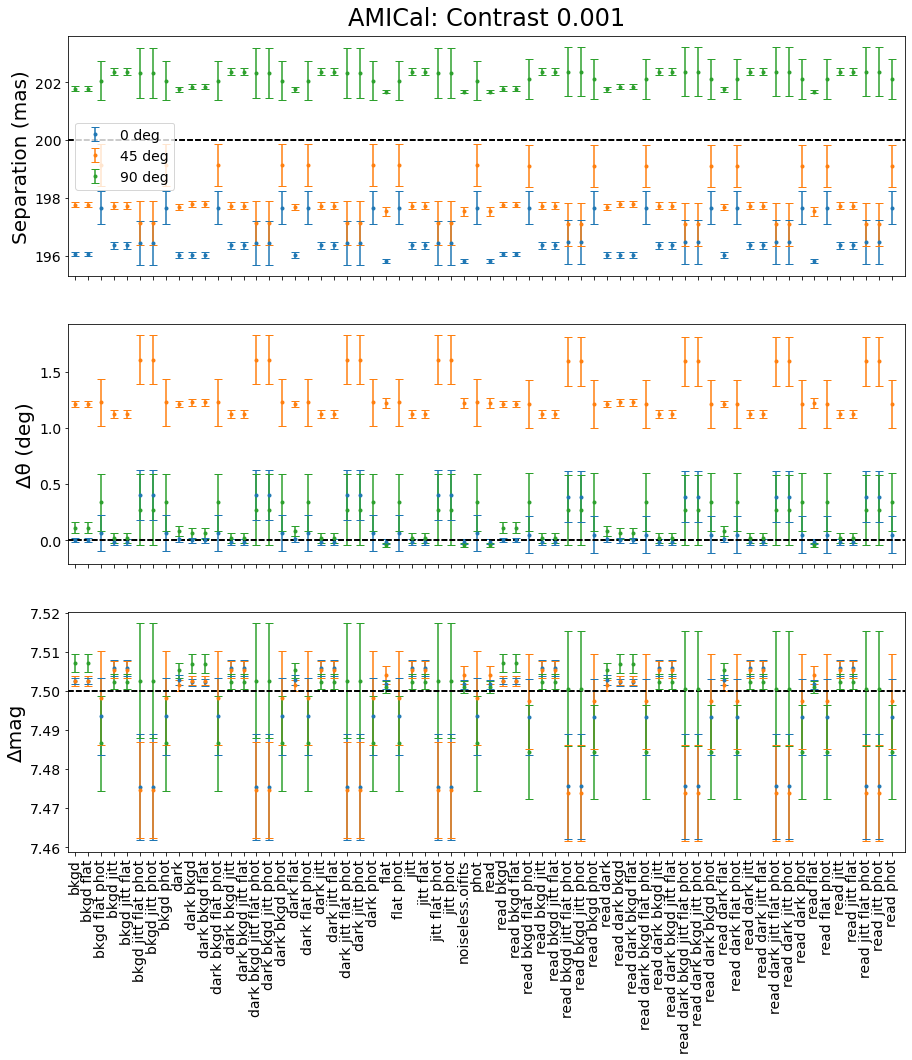

In [12]:
plot_all(0.001,dataset=data3,pipeline='AMICal')